# Sentiment Analysis

#### Importing useful libraries

In [3]:
# Import libraries
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from textblob import TextBlob
import matplotlib.pyplot as plt
import mplcursors
import plotly.express as px
from datetime import datetime

#NLP libraries 
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from textblob import TextBlob

import yfinance as yf

#from scipy import stats as stat

### twitter_tweets dataset import

In [4]:
# Import Dataset
tweets_ds = pd.read_csv("../datasets/twitter/twitter_tweets.csv", chunksize=100000, lineterminator='\n', low_memory=False)
tweets_df = pd.concat(tweets_ds)

tweets_df.info()
tweets_df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4792264 entries, 0 to 4792263
Data columns (total 8 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   tweet_id       int64 
 1   created_at     object
 2   author_id      int64 
 3   content        object
 4   retweet_count  int64 
 5   reply_count    int64 
 6   like_count     int64 
 7   quote_count    int64 
dtypes: int64(6), object(2)
memory usage: 292.5+ MB


(4792264, 8)

In [5]:
# we assiacure that there are no cells with null values in the date and text columns
tweets_df.dropna(axis=0 ,subset=['created_at', 'content'],inplace = True)
tweets_df.reset_index(drop= True,inplace=True)
tweets_df.shape

(4792264, 8)

In [6]:
# Check for null values
null_values = tweets_df.isnull().sum()
print("Null values in each column:\n", null_values)

# Check for duplicates
duplicate_rows = tweets_df.duplicated().sum()
print("Number of duplicate rows:", duplicate_rows)

Null values in each column:
 tweet_id         0
created_at       0
author_id        0
content          0
retweet_count    0
reply_count      0
like_count       0
quote_count      0
dtype: int64
Number of duplicate rows: 0


In [7]:
# Data cleaning 
tweets_df.drop_duplicates(inplace = True)
tweets_df.reset_index(drop=True,inplace=True)
tweets_df.shape

(4792264, 8)

In [8]:
# Setting dataset column types
tweets_df = tweets_df.convert_dtypes()
tweets_df.dtypes

tweet_id                  Int64
created_at       string[python]
author_id                 Int64
content          string[python]
retweet_count             Int64
reply_count               Int64
like_count                Int64
quote_count               Int64
dtype: object

In [9]:
# Check which of the rows don't have an actuall date in the 'date' column
def validate(date_text):
    errors = []
    for i,v in enumerate(date_text):
        try:
            datetime.strptime(v, '%Y-%m-%d %H:%M:%S')
        except ValueError:
            errors.append(i)
    return errors

In [10]:
# Print number of date not valid
errors = validate(tweets_df['created_at'])
print('There are '+ str(len(errors)) + ' values that are not actual dates in the created_at column')

There are 0 values that are not actual dates in the created_at column


### Date of first tweet and last tweet

In [11]:
# First and last tweet in time order
# Sort the DataFrame by the 'created_at' column
tweets_df = tweets_df.sort_values(by='created_at')

# Get the first and last tweet
primo_tweet = tweets_df.iloc[0]
ultimo_tweet = tweets_df.iloc[-1]

# Print the results
print("First tweet:")
print(primo_tweet['created_at'])

print("\nLast tweet:")
print(ultimo_tweet['created_at'])

First tweet:
2017-01-06 21:42:43

Last tweet:
2022-02-23 23:57:21


### Total score calculation of tweets with weights assigned to variables such as like, quote, reply, and retweet. Sorting of tweets based on the total score in descending order

In [12]:
# Definisci pesi per like, quote, reply e retweet
peso_like = 1
peso_reply = 2
peso_retweet = 3
peso_quote = 3

# Normalizza i valori dei vari aspetti
scaler = MinMaxScaler()
tweet_features = scaler.fit_transform(tweets_df[['like_count', 'quote_count', 'reply_count', 'retweet_count']])

# Calcola il punteggio totale per ciascun tweet
tweets_df['punteggio_totale'] = (
    tweet_features[:, 0] * peso_like + 
    tweet_features[:, 1] * peso_reply + 
    tweet_features[:, 2] * peso_retweet + 
    tweet_features[:, 3] * peso_quote 
)

# Ordina il DataFrame in base al punteggio totale in ordine decrescente (più influenti)
tweets_df_sorted_desc = tweets_df.sort_values(by='punteggio_totale', ascending=False)
tweets_df_sorted_desc['data'] = pd.to_datetime(tweets_df_sorted_desc['created_at']).dt.date


print("Tweet più influenti:")
print(tweets_df_sorted_desc[['tweet_id', 'like_count', 'quote_count', 'reply_count', 'retweet_count', 'punteggio_totale', 'data']])


Tweet più influenti:
                    tweet_id  like_count  quote_count  reply_count  \
871365   1454653822849011713       42682         2219        13137   
2218350  1484230264293318663      192137        10642        12575   
1639231  1474743503393628164       11027          243        17238   
765175   1459164143626424321       33156         5759         8598   
2116372  1486482496883625984       20161         7196         7281   
...                      ...         ...          ...          ...   
533263   1464353282776870924           0            0            0   
533262   1464353288657293313           0            0            0   
533261   1464353308005605378           0            0            0   
533260   1464353317547646984           0            0            0   
4792202  1496635323744280577           0            0            0   

         retweet_count  punteggio_totale        data  
871365           76411          5.882075  2021-10-31  
2218350          13270      

### Create a graphic for the total score with month and year

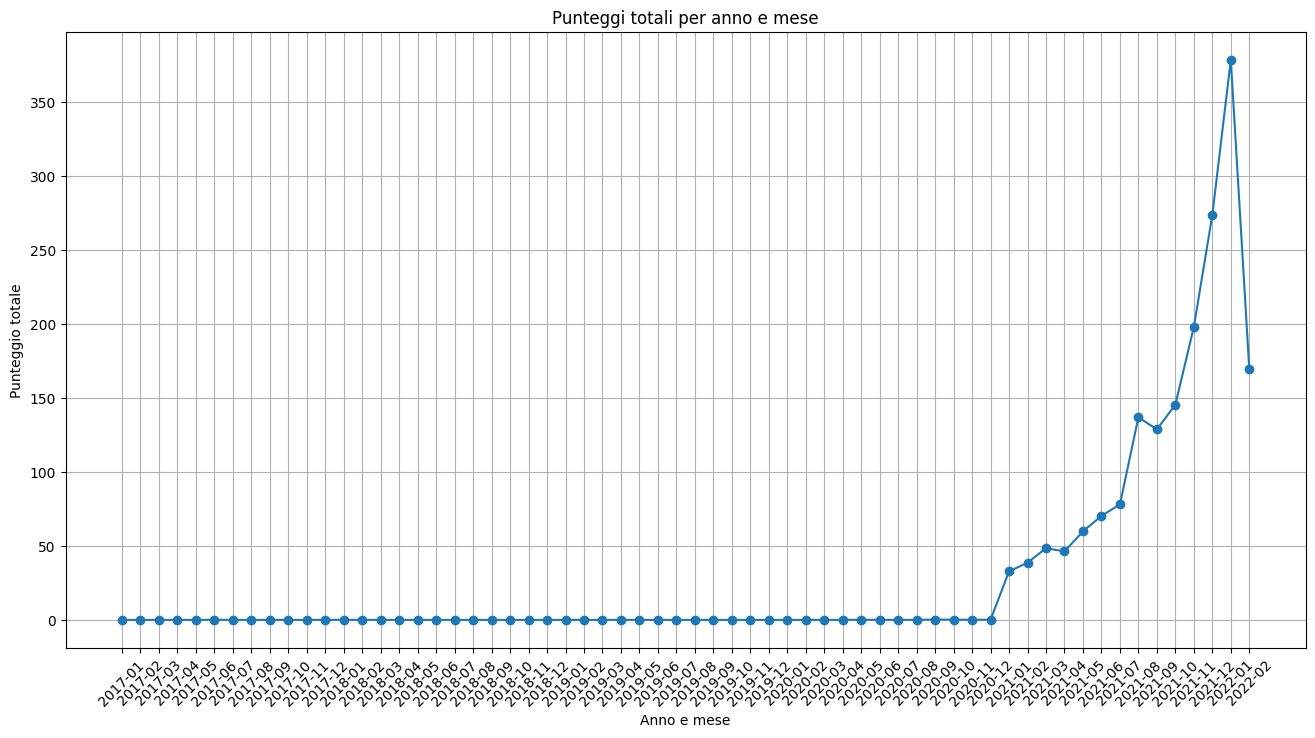

In [13]:
# Converti 'data' di nuovo in datetime per usare l'accessor dt
tweets_df_sorted_desc['data'] = pd.to_datetime(tweets_df_sorted_desc['data'])

# Calcola i punteggi totali per anno e mese
punteggi_totali_per_anno_mese = tweets_df_sorted_desc.groupby([tweets_df_sorted_desc['data'].dt.year, tweets_df_sorted_desc['data'].dt.month])['punteggio_totale'].sum()

# Converti l'indice in formato di stringa "Anno-Mese"
indice_stringa = punteggi_totali_per_anno_mese.index.map(lambda x: f"{x[0]}-{x[1]:02d}")

# Crea il grafico con dimensioni più grandi
plt.figure(figsize=(16, 8))  # Aumenta le dimensioni della figura
plt.plot(indice_stringa, punteggi_totali_per_anno_mese.values, marker='o', linestyle='-')
plt.title('Punteggi totali per anno e mese')
plt.xlabel('Anno e mese')
plt.ylabel('Punteggio totale')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

### Filtering

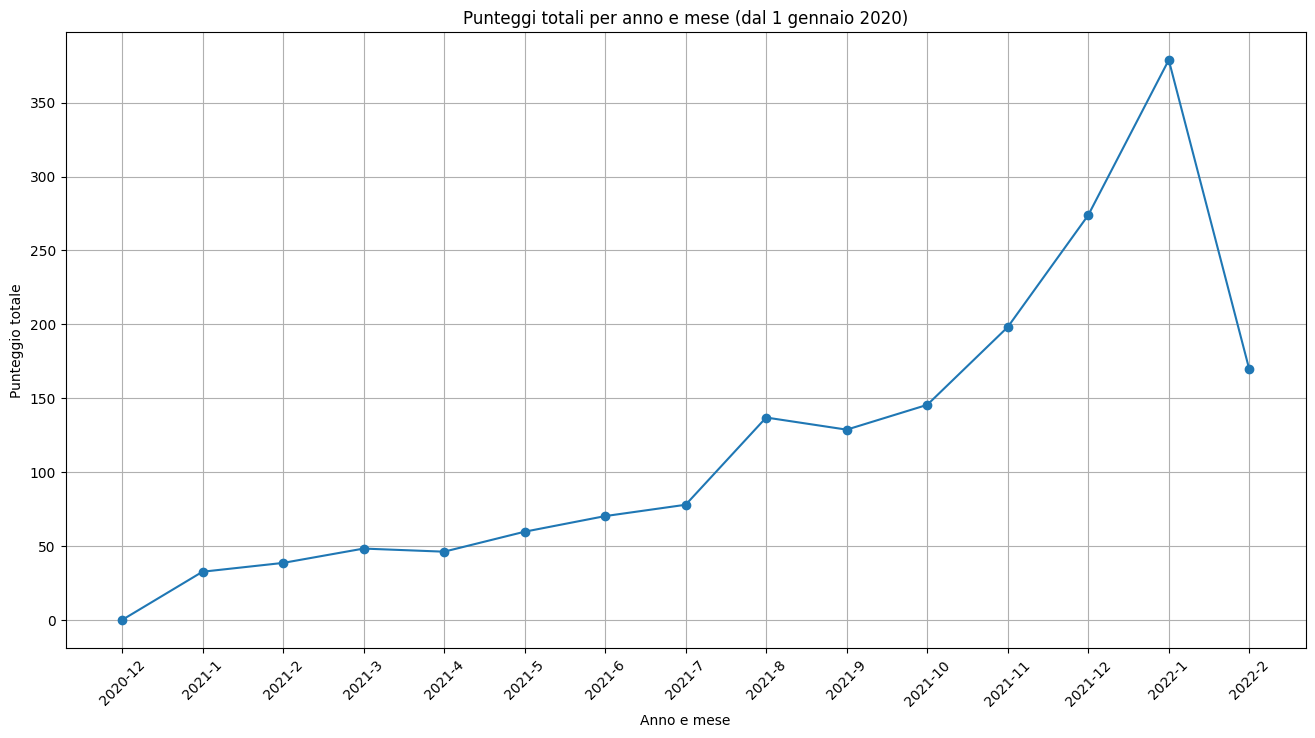

In [14]:
# Filtra i tweet dal 1 gennaio 2020 fino alla fine del dataset
tweets_filtrati = tweets_df_sorted_desc[tweets_df_sorted_desc['data'] >= pd.Timestamp('2020-12-01')]

# Calcola i punteggi totali per anno e mese dei tweet filtrati
punteggi_totali_per_anno_mese = tweets_filtrati.groupby([tweets_filtrati['data'].dt.year, tweets_filtrati['data'].dt.month])['punteggio_totale'].sum()

# Converti l'indice in formato di stringa "Anno-Mese"
indice_stringa = punteggi_totali_per_anno_mese.index.map(lambda x: f"{x[0]}-{x[1]}")

# Crea il grafico con dimensioni più grandi
plt.figure(figsize=(16, 8))
plt.plot(indice_stringa, punteggi_totali_per_anno_mese.values, marker='o', linestyle='-')
plt.title('Punteggi totali per anno e mese (dal 1 gennaio 2020)')
plt.xlabel('Anno e mese')
plt.ylabel('Punteggio totale')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


In [15]:
tweets_df['created_at'] = pd.to_datetime(tweets_df['created_at'], format='%Y-%m-%d %H:%M:%S')
tweets_df_final = tweets_df.loc[(tweets_df['created_at'] >= '2020-12-01')].reset_index(drop=True)
tweets_df_final.shape

(4779585, 9)

### twitter_tweet_hashtag dataset import

In [16]:
# Import Dataset
hashtag_ds = pd.read_csv("../datasets/twitter/twitter_tweet_hashtag.csv", chunksize=100000, lineterminator='\n', low_memory=False)
hashtag_df = pd.concat(hashtag_ds)

hashtag_df.info()
hashtag_df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7337482 entries, 0 to 7337481
Data columns (total 2 columns):
 #   Column    Dtype 
---  ------    ----- 
 0   tweet_id  int64 
 1   hashtag   object
dtypes: int64(1), object(1)
memory usage: 112.0+ MB


(7337482, 2)

In [17]:
# we assiacure that there are no cells with null values in the date and text columns
hashtag_df.dropna(axis=0 ,subset=['tweet_id', 'hashtag'],inplace = True)
hashtag_df.reset_index(drop= True,inplace=True)
hashtag_df.shape

(7337480, 2)

In [18]:
# Check for null values
null_values = hashtag_df.isnull().sum()
print("Null values in each column:\n", null_values)

# Check for duplicates
duplicate_rows = hashtag_df.duplicated().sum()
print("Number of duplicate rows:", duplicate_rows)

Null values in each column:
 tweet_id    0
hashtag     0
dtype: int64
Number of duplicate rows: 0


In [19]:
# Data cleaning 
hashtag_df.drop_duplicates(inplace = True)
hashtag_df.reset_index(drop=True,inplace=True)
hashtag_df.shape

(7337480, 2)

In [20]:
# Setting dataset column types
hashtag_df = hashtag_df.convert_dtypes()
hashtag_df.dtypes

tweet_id             Int64
hashtag     string[python]
dtype: object

### Hashtags list

In [42]:
# Assicura che la colonna 'hashtags' sia di tipo stringa
hashtag_df['hashtag'] = hashtag_df['hashtag'].astype(str)

# Crea una lista di tutti gli hashtag
all_hashtags = []
for hashtags_str in hashtag_df['hashtag']:
    # Rimuove eventuali caratteri indesiderati e divide per ottenere una lista di hashtag
    hashtags = [tag.strip("[]'") for tag in hashtags_str.split(', ')]
    all_hashtags.extend(hashtags)

# Rimuove eventuali caratteri speciali dagli hashtag
all_hashtags = [tag.strip("#") for tag in all_hashtags]

# Conta la frequenza degli hashtag
hashtags_frequenza = pd.Series(all_hashtags).value_counts()
# Conta il numero totale di hashtag
total_hashtags = len(hashtags_frequenza)
print("Total number of hashtags:", total_hashtags)

# Filtra gli hashtag che contengono almeno una delle parole chiave relative agli NFT
nft_keywords = ["nft", "cryptopunks", "bayc", "nfts", "nftcommunity", "nftart", "nftcollector", "opensea", "ethereum", "cryptopunk"]
filtered_hashtags = hashtags_frequenza[hashtags_frequenza.index.str.contains('|'.join(nft_keywords))]

# Stampa gli hashtag rilevanti insieme alla loro frequenza
print("Hashtags related to NFT and their counts:")
print(filtered_hashtags)

Total number of hashtags: 185131
Hashtags related to NFT and their counts:
nft                517794
cryptopunks        310915
bayc               306206
nfts               287180
nftcommunity       224366
                    ...  
nftchampion             1
parodynft               1
nftfollectibles         1
nftthaiㅜ                1
nftcn                   1
Name: count, Length: 10024, dtype: int64


### Hashtags più influenti visibili graficamente

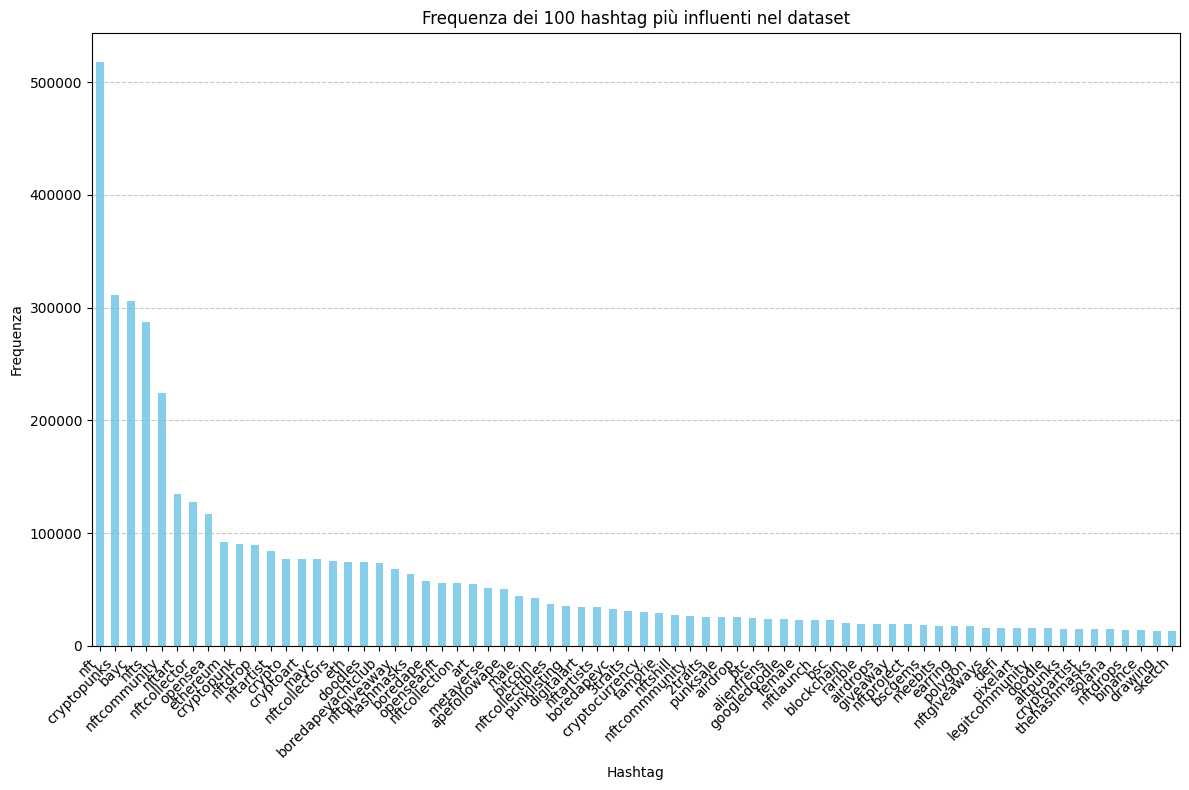

In [22]:
# Per vedere gli hashtags più frequenti nel grafico (70)
hashtags_influenti = hashtags_frequenza.head(70)

# Crea un grafico a barre per visualizzare la frequenza degli hashtag più influenti
plt.figure(figsize=(12, 8))
hashtags_influenti.plot(kind='bar', color='skyblue')
plt.title('Frequenza dei 100 hashtag più influenti nel dataset')
plt.xlabel('Hashtag')
plt.ylabel('Frequenza')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


### Filtering of hashtags list

## DECIDERE FINO A QUANTI HASTAG VOGLIAMO TENERE, VEDERE SOPRA CHE OLTRE AL GRAFICO HO STAMPATO GLI HASHTAG CON PAROLE CHIAVI CON DI FIANCO IL NUMERO DI VOLTE CHE VENGONO UTILIZZATI 
## FINO A QUANTO LI FILTRIAMO? SICCOME SIAMO IJN TANTI FACCIAMO UN'ESAMINAZIONE PIù APPROFONDITA
## ARRIVATA FINO A QUI TROVARE I TWEET DOVE CI SONO GLI HASTAG RACCOLTI SOPRA 

### Sentiment Analysis

In [25]:
# Funzione per l'analisi del sentiment
def analyze_sentiment(text):
    # Crea un oggetto TextBlob dal testo del tweet
    blob = TextBlob(text)
    # Restituisce la polarità del sentiment
    return blob.sentiment.polarity

# Applica la funzione di analisi del sentiment al contenuto dei tweet
tweets_df['sentiment_polarity'] = tweets_df['content'].apply(analyze_sentiment)

# Stampa i tweet con la polarità del sentiment
print("Sentiment Analysis dei tweet:")
print(tweets_df[['tweet_id', 'content', 'sentiment_polarity']])

KeyboardInterrupt: 